![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/regression/auto-ml-regression.png)

In [1]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.core.datastore import Datastore
from azureml.core.dataset import Dataset
from azureml.data.data_reference import DataReference
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
print(azureml.core.VERSION) #should be 1.0.57 or greater

1.0.57


In [2]:
ws = Workspace.from_config()
experiment_name = 'house_prices_regression'
project_folder = './sample_projects/house_prices_regression'
experiment = Experiment(ws, experiment_name)

## Data
This uses the AzureML datastore and dataset api's, as well as data manipulation, with keep_ and drop_ columns, and random_split.

In [3]:
datastore_name = 'edvanstorage__azureml'
dataset_path = 'boston_houses/boston_data.csv'
datastore = Datastore.get(ws, datastore_name)
data_reference = DataReference(datastore, data_reference_name="boston_data", path_on_datastore=dataset_path)
boston_ds = Dataset.Tabular.from_delimited_files(data_reference)
boston_ds = boston_ds.drop_columns('Column1')
boston_ds.take(3).to_pandas_dataframe()

,CrimeRate,ResidentialZoning,IndustrialZoning,OnRiver,NOXConcentration,NumberOfRooms,PreWarHouses,DistanceToEmployment,DistanceToHighways,PropertyTaxRate,ParentTeachRatio,ProportionAA,LowerStatusProportion,Price
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70


In [5]:
b_train, b_test = boston_ds.random_split(0.2, seed=84)
X_train = b_train.drop_columns('Price')
y_train = b_train.keep_columns('Price')
X_test = b_test.drop_columns('Price')
y_test = b_test.keep_columns('Price')

## Remote compute
Setup the environments for remote compute, we might not need it...

In [6]:
compute_target = ws.compute_targets['cpucluster']
run_config = RunConfiguration(framework="python")
run_config.target = compute_target
run_config.environment.docker.enabled = True
run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE

dependencies = CondaDependencies.create(
    pip_packages=["scikit-learn", "scipy", "numpy"])
run_config.environment.python.conda_dependencies = dependencies

## Train

Instantiate an `AutoMLConfig` object to specify the settings for both local and remote runs and data used to run the experiment.

In [7]:
aml_config = {"task": 'regression',
         "iteration_timeout_minutes": 10,
         "primary_metric": 'normalized_root_mean_squared_error',
         "debug_log": 'automl.log',
         "verbosity": logging.INFO,
         "enable_early_stopping": True,
         "X": X_train, 
         "y": y_train,
         "path": project_folder}

local_run = True
if local_run:
    numb_run_config = {
        'iterations': 10,
        'n_cross_validations': 5
    }
else:
    numb_run_config = {
        'iterations': 250,
        'n_cross_validations': 10
    }    
    remote_config = {
        'compute_target': compute_target,
        'run_configuration': run_config,
        'max_cores_per_iteration': 2,
        'max_concurrent_iterations': 20,
    }
    aml_config.update(remote_config)
aml_config.update(numb_run_config)
    
automl_config = AutoMLConfig(**aml_config)

In [8]:
show_run = False
if 'compute_target' in aml_config:
    print(f"Running {aml_config['iterations']} iterations on remote compute (with {compute_target.vm_size} VM's), with {aml_config['n_cross_validations']}-fold cross validation.")
else:
    print(f"Running {aml_config['iterations']} iterations on local compute, with {aml_config['n_cross_validations']}-fold cross validation.")
if not show_run:
    print("Not showing output here. Please run the Widget cell below.")
else:
    print("---------------------------------------------------------------------------------")
run = experiment.submit(automl_config, show_output = show_run)

Running 10 iterations on local compute, with 5-fold cross validation.
Not showing output here. Please run the Widget cell below.


In [9]:
from azureml.widgets import RunDetails
RunDetails(run).show() 

ModuleNotFoundError: No module named 'azureml.widgets'

In [10]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
house_prices_regression,AutoML_09a5a593-af18-405d-b0e7-6c5c2b2e3578,automl,Completed,Link to Azure Portal,Link to Documentation



#### Retrieve All Child Runs
You can also use SDK methods to fetch all the child runs and see individual metrics that we log.

In [11]:
children = list(run.get_children())
metricslist = {}
for r in children:
    properties = r.get_properties()
    metrics = {k: v for k, v in r.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
explained_variance,0.70,0.71,0.76,0.79,0.80,0.64,0.51,0.80,0.83,0.82
mean_absolute_error,2.98,3.00,2.50,2.35,2.24,3.00,3.36,2.27,1.98,2.10
mean_absolute_percentage_error,14.71,14.90,13.30,12.84,12.38,16.27,16.48,11.61,10.31,10.75
median_absolute_error,2.32,2.40,1.86,1.74,1.68,2.26,2.22,1.68,1.34,1.48
normalized_mean_absolute_error,0.07,0.07,0.06,0.05,0.05,0.07,0.08,0.05,0.05,0.05
normalized_median_absolute_error,0.05,0.06,0.04,0.04,0.04,0.05,0.05,0.04,0.03,0.03
normalized_root_mean_squared_error,0.09,0.09,0.08,0.08,0.08,0.09,0.12,0.08,0.07,0.07
normalized_root_mean_squared_log_error,0.10,0.10,0.11,0.08,0.08,0.09,0.11,0.08,0.07,0.08
r2_score,0.68,0.68,0.75,0.79,0.80,0.63,0.50,0.79,0.83,0.81
root_mean_squared_error,3.97,3.96,3.48,3.38,3.23,4.05,4.96,3.36,2.96,3.13


### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [13]:
best_run, fitted_model = run.get_output()
print(best_run)
print("----------------------------")
print(fitted_model)

Run(Experiment: house_prices_regression,
Id: AutoML_09a5a593-af18-405d-b0e7-6c5c2b2e3578_8,
Type: None,
Status: Completed)
----------------------------
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('4', RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x00000210BBB795C0>), ('LightGBMRegressor', LightGB...3333333333333333, 0.1111111111111111, 0.1111111111111111, 0.3333333333333333, 0.1111111111111111]))]),
          stddev=None)


#### Best Model Based on Any Other Metric
Show the run and the model that has the smallest `root_mean_squared_error` value (which turned out to be the same as the one with largest `spearman_correlation` value):

In [14]:
lookup_metric = "spearman_correlation"
best_run, fitted_model = run.get_output(metric = lookup_metric)
print(best_run)
print("----------------------------")
print(fitted_model)

Run(Experiment: house_prices_regression,
Id: AutoML_09a5a593-af18-405d-b0e7-6c5c2b2e3578_8,
Type: None,
Status: Completed)
----------------------------
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('4', RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x00000210BBBB4EF0>), ('LightGBMRegressor', LightGB...3333333333333333, 0.1111111111111111, 0.1111111111111111, 0.3333333333333333, 0.1111111111111111]))]),
          stddev=None)


#### Model from a Specific Iteration
Show the run and the model from the third iteration:

In [15]:
iteration = 3
third_run, third_model = run.get_output(iteration = iteration)
print(third_run)
print("----------------------------")
print(third_model)

Run(Experiment: house_prices_regression,
Id: AutoML_09a5a593-af18-405d-b0e7-6c5c2b2e3578_3,
Type: None,
Status: Completed)
----------------------------
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x00000210BBB64208>), ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impuri...timators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          stddev=None)


## Test

Predict on training and test set, and calculate residual values.

In [16]:
X_train_pd = X_train.to_pandas_dataframe()
y_train_pd = y_train.to_pandas_dataframe().squeeze()
X_test_pd = X_test.to_pandas_dataframe()
y_test_pd = y_test.to_pandas_dataframe().squeeze()

y_pred_train = fitted_model.predict(X_train_pd)
y_residual_train = y_train_pd - y_pred_train

y_pred_test = fitted_model.predict(X_test_pd)
y_residual_test = y_test_pd - y_pred_test

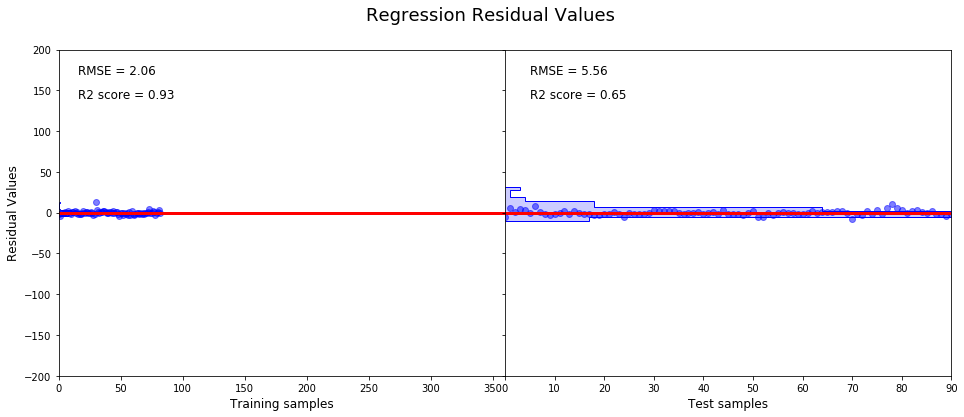

In [17]:
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -200, 200])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train_pd, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train_pd, y_pred_train)), fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot a histogram.
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step')
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10)

# Plot residual values of test set.
a1.axis([0, 90, -200, 200])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test_pd, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test_pd, y_pred_test)), fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

# Plot a histogram.
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step')
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10)

plt.show()

In [18]:
all_rmse = {}
for ite in range(aml_config['iterations']):
    i_run, model = run.get_output(iteration = ite)
    y_pred_test = model.predict(X_test_pd)
    all_rmse[ite] = np.sqrt(mean_squared_error(y_test_pd, y_pred_test))

In [19]:
all_rmse

{0: 6.064030259958559,
 1: 5.984815647740433,
 2: 5.46177975902496,
 3: 6.12410911357629,
 4: 5.756417944463689,
 5: 5.31859770812225,
 6: 7.360652958667145,
 7: 5.63576205565765,
 8: 5.560681814172822,
 9: 5.38547583742528}

In [21]:
best_iteration = sorted(all_rmse, key=all_rmse.get, reverse=False)[0]
print(f'Best iteration is number {best_iteration}')
print("--------------")
best_test_run, best_test_model = run.get_output(iteration = best_iteration)
print(best_test_run)
print(best_test_run.get_file_names())
print("--------------")
print(best_test_model)
# print(best_test_model.get_model_path())

Best iteration is number 5
Run(Experiment: house_prices_regression,
Id: AutoML_09a5a593-af18-405d-b0e7-6c5c2b2e3578_5,
Type: None,
Status: Completed)
['outputs/conda_env_v_1_0_0.yml', 'outputs/env_dependencies.json', 'outputs/internal_cross_validated_models.pkl', 'outputs/model.pkl', 'outputs/scoring_file_v_1_0_0.py', 'predicted_true', 'residuals']
--------------
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x00000210BDDD8860>), ('LassoLars', LassoLars(alpha=0.001, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False))]),
          stddev=None)


In [22]:
dependencies = run.get_run_sdk_dependencies(iteration = best_iteration)

In [23]:
for p in ['azureml-train-automl', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	1.0.57
azureml-core	1.0.57.1


In [24]:
myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn','py-xgboost==0.80'], pip_packages=['azureml-train-automl'])

conda_env_file_name = 'conda_dependencies.yml'
myenv.save_to_file('.', conda_env_file_name)

'conda_dependencies.yml'

## Register model (and commit code pieces first)
Since the Release is triggered from a new version of the model, that is done last.

In [46]:
changes = !git diff
if len(changes) > 0:
    print("Changes to commit. Committing and pushing now")
    !git commit -am "Commit from NB"
    !git push    
else:
    print("No changes to commit.")

No changes to commit.


In [25]:
name = "house_prices_regression"
deploy = True

# best_test_model.register(ws, )
model = best_test_run.register_model(name, model_path='outputs/model.pkl')
print(model.name, model.id, model.version, sep='\t')

house_prices_regression	house_prices_regression:3	3
